This notebook takes in as input:
* GeoJSON with building footprint polygons
* GDB files with damage points
* GeoTIFF tiles of satellite imaging

It then
1) Identifies damaged buildings by joining the first two datasets,
2) Identifies in which tiles those buildings are located, and
3) Crops out area of damaged buildings from the input rasters.

The output is 128x128 images of buildings, with their centroid
coordinates as filenames. 

In [1]:
import geopandas as gpd
import os
import pandas as pd
import rasterio
import shapely

# Keep CRS consistent, always use espg:4326
CRS = {'init':'epsg:4326'}

In [2]:
# Geojson file with building polygons. Obtained from OSM via Geofabrik (http://download.geofabrik.de/)
buildings = gpd.read_file('/Users/apando/school/cs230/project/datasets/hurricane_maria/ground_truth/buildings/buildings.geojson')


In [3]:
print(len(buildings))
buildings.head()

1498316


,geometry
0,"POLYGON ((-66.04452809999999 18.4021147, -66.0..."
1,"POLYGON ((-66.0463973 18.4021623, -66.0463973 ..."
2,"POLYGON ((-66.0483139 18.4023847, -66.0483112 ..."
3,"POLYGON ((-66.0485137 18.4023866, -66.04864739..."
4,"POLYGON ((-66.0470406 18.4073665, -66.0470528 ..."


In [4]:
# Directory containing *.gdb files from FEMA with damage points from visual assessment 
# (https://data.femadata.com/NationalDisasters/HurricaneMaria/Data/DamageAssessments/)
damage_dir = '/Users/apando/school/cs230/project/datasets/hurricane_maria/ground_truth/damage'
damage_list = []
for gdb_dir in os.listdir(damage_dir):
    if gdb_dir.endswith('.gdb'):
        dmg = gpd.read_file(damage_dir + "/" + gdb_dir)
        print("Appending {} damage points".format(len(dmg)))
        damage_list.append(dmg)
        
damage_pts = gpd.GeoDataFrame(pd.concat(damage_list, ignore_index=True), crs=CRS)

print("Added {0} damage points from {1} datasets".format(len(damage_pts), len(damage_list)))

Appending 12837 damage points
Appending 9264 damage points
Appending 28028 damage points
Appending 18728 damage points
Appending 35357 damage points
Appending 30788 damage points
Appending 17529 damage points
Appending 53664 damage points
Appending 14314 damage points
Appending 50116 damage points
Appending 46190 damage points
Appending 9672 damage points
Added 326487 damage points from 12 datasets


In [6]:
print(damage_pts['DMG_LEVEL'].unique())
damage_pts.head()


['AFF' 'DES']


,DMG_LEVEL,DMG_TYPE,ASMT_TYPE,IN_DEPTH,WIND_SPEED,PGA,ACCESS,COUNTY,STATE,FIPS,...,IMG_DATE,EVENT_NAME,EVENT_DATE,SOURCE,DIS_NUMBER,COMMENTS,LONGITUDE,LATITUDE,USNG,geometry
0,AFF,WI,RS,None,UNK,None,UNK,,,None,...,None,Hurricane Maria,None,FEMA,None,None,-64.885643,17.690947,None,POINT (-64.88563929799994 17.69094600000005)
1,AFF,WI,RS,None,UNK,None,UNK,,,None,...,None,Hurricane Maria,None,FEMA,None,None,-64.885376,17.691029,None,POINT (-64.88537952399997 17.69102889900006)
2,AFF,WI,RS,None,UNK,None,UNK,,,None,...,None,Hurricane Maria,None,FEMA,None,None,-64.884247,17.691402,None,POINT (-64.88424604499994 17.69140229300007)
3,AFF,WI,RS,None,UNK,None,UNK,,,None,...,None,Hurricane Maria,None,FEMA,None,None,-64.885277,17.691416,None,POINT (-64.88527374699999 17.69141608300004)
4,AFF,WI,RS,None,UNK,None,UNK,,,None,...,None,Hurricane Maria,None,FEMA,None,None,-64.886742,17.691389,None,POINT (-64.88674052199997 17.69138884300003)


## Damage labels


| Value | Label |
| ------|:-----:|
| NOD | No Damage |
| UNK | Unknown |
| AFF | Affected |
| MIN | Minor |
| MAJ | Major |
| DES | Destroyed |

Keep this in mind when doing analysis!

Source: https://gis.fema.gov/arcgis/rest/services/FEMA/FEMA_Damage_Assessments/MapServer/0


In [5]:
# Map damage points to buildings. For our experiment, we will not include 
# damage points that don't have a building associated with them, as we are
# specifically looking for damaged buildings.

# Right join to keep the building polygons
buildings_dmg_points = gpd.sjoin(damage_pts, buildings, how="right", op="within")

# Split damaged and non-damaged buildings
damaged_buildings = buildings_dmg_points[pd.notnull(buildings_dmg_points['index_left'])]
non_damaged_buildings = buildings_dmg_points[~pd.notnull(buildings_dmg_points['index_left'])]

print("Found {0} damaged buildings and {1} non-damaged buildings".format(len(damaged_buildings), len(non_damaged_buildings)))

Found 245744 damaged buildings and 1457071 non-damaged buildings


In [6]:
damaged_buildings['is_damaged'] = True
non_damaged_buildings['is_damaged'] = False
all_buildings = pd.concat([damaged_buildings, non_damaged_buildings], ignore_index=True)

print("{} total buildings".format(len(all_buildings)))

/Users/apando/miniconda3/envs/disaster-detection/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/apando/miniconda3/envs/disaster-detection/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


1702815 total buildings


In [7]:
# We will likely have a harder time classifying less-damaged buildings correctly. 
damaged_buildings['DMG_LEVEL'].value_counts()

AFF    230053
DES     15691
Name: DMG_LEVEL, dtype: int64

In [36]:
# Find the tiles each these buildings is in.

# First, map tiles to their bounding box polygons.
# Root dir is the high-level directory where tiles are located.
tile_coords_map = pd.DataFrame(columns=['tile_filename', 'tile_bbox'])
tile_coords_list = []
num_tiles = 0
for curr_dir, _, file_list in os.walk('/Users/apando/school/cs230/project/datasets/hurricane_maria/post_event'):
    for fname in file_list:
        # Do not include pyramids, which are stored in a /1 dir with in the tiles/ directory.
        if not curr_dir.endswith('1') and fname.endswith(".tif"):
            num_tiles += 1
            tile_loc = curr_dir + "/" + fname
            
            # Find the bounding box of the tile to form a mapping DataFrame
            tile = rasterio.open(tile_loc)
            tile_coords_list.append((tile_loc, 
                                     (tile.bounds.left, tile.bounds.bottom, tile.bounds.right, tile.bounds.top)))
            
            if num_tiles % 1000 == 0:
                print("Processed {0} tiles... curr tile: {1}".format(num_tiles, fname))

tile_coords_map_cols = list(map(list, zip(*tile_coords_list)))
tile_coords_map = gpd.GeoDataFrame({'tile_filename': tile_coords_map_cols[0], 
                                    'tile_bbox': list(map(lambda x: shapely.geometry.box(*x), 
                                                          tile_coords_map_cols[1]))},
                                  geometry='tile_bbox', crs=CRS)

print("Mapped {} tiles to bboxes".format(len(tile_coords_map)))

Processed 1000 tiles... curr tile: 2020100_jpeg_compressed_04_08.tif
Processed 2000 tiles... curr tile: 2020120_2_jpeg_compressed_02_07.tif
Processed 3000 tiles... curr tile: 2020110_2_jpeg_compressed_09_07.tif
Processed 4000 tiles... curr tile: 2020130_3_jpeg_compressed_08_09.tif
Processed 5000 tiles... curr tile: 2021012_jpeg_compressed_10_05.tif
Processed 6000 tiles... curr tile: 2003232_jpeg_compressed_04_05.tif
Processed 7000 tiles... curr tile: 2012331_jpeg_compressed_07_01.tif
Processed 8000 tiles... curr tile: 2003121_jpeg_compressed_07_06.tif
Processed 9000 tiles... curr tile: 1220103_2_jpeg_compressed_02_08.tif
Processed 10000 tiles... curr tile: 1202331_2_jpeg_compressed_01_06.tif
Processed 11000 tiles... curr tile: 1202303_1_jpeg_compressed_08_10.tif
Processed 12000 tiles... curr tile: 1222021_jpeg_compressed_10_06.tif
Mapped 12859 tiles to bboxes


In [38]:
# Map buildings to the tiles they're in to crop them out

# Drop index from the previous join (we don't need it anymore)
all_buildings = all_buildings.drop(['index_left'], axis=1)
buildings_tile_map = gpd.sjoin(all_buildings, tile_coords_map, how="left", op="within")

# Remove buildings for which we don't have any satellite images
buildings_tile_map = buildings_tile_map[pd.notnull(buildings_tile_map['tile_filename'])]

# Note that it's possible for there to be more rows here than # of buildings,
# because we likely have more than 1 tile for the same buildings.
# To avoid biasing by having the same building in train/test/dev sets,
# the filename with building centroid coords will indicate whether it's the 
# same building or not and we can filter accordingly.
print(len(buildings_tile_map))
buildings_tile_map.head()

1084698


,DMG_LEVEL,DMG_TYPE,ASMT_TYPE,IN_DEPTH,WIND_SPEED,PGA,ACCESS,COUNTY,STATE,FIPS,...,SOURCE,DIS_NUMBER,COMMENTS,LONGITUDE,LATITUDE,USNG,geometry,is_damaged,index_right,tile_filename
10,AFF,WI,RS,None,UNK,None,UNK,,,None,...,FEMA,DR-4339,None,-66.125748,18.440516,None,"POLYGON ((-66.1261362 18.4406596, -66.1257715 ...",True,7780.0,/Users/apando/school/cs230/project/datasets/hu...
11,AFF,WI,RS,None,UNK,None,UNK,,,None,...,FEMA,None,None,-66.125748,18.440516,None,"POLYGON ((-66.1261362 18.4406596, -66.1257715 ...",True,7780.0,/Users/apando/school/cs230/project/datasets/hu...
12,AFF,WI,RS,None,UNK,None,UNK,,,None,...,FEMA,None,None,-66.125748,18.440516,None,"POLYGON ((-66.1261362 18.4406596, -66.1257715 ...",True,7780.0,/Users/apando/school/cs230/project/datasets/hu...
13,AFF,WI,RS,None,UNK,None,UNK,,,None,...,FEMA,None,None,-66.125748,18.440516,None,"POLYGON ((-66.1261362 18.4406596, -66.1257715 ...",True,7780.0,/Users/apando/school/cs230/project/datasets/hu...
14,AFF,WI,RS,None,UNK,None,UNK,,,None,...,FEMA,DR-4339,None,-66.125748,18.440516,None,"POLYGON ((-66.1261362 18.4406596, -66.1257715 ...",True,7780.0,/Users/apando/school/cs230/project/datasets/hu...


481753


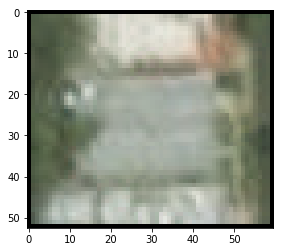

/Users/apando/school/cs230/project/datasets/hurricane_maria/post_event/20170924/tiles/2030003_jpeg_compressed_06_06.tif


In [90]:
# Explore different zoom levels
# First zoom level (pre-tuning): 0.00016

import random
from rasterio.mask import mask
from rasterio import plot

i = int(random.random()*len(buildings_tile_map))
print(i)
i = 666242
row = buildings_tile_map.iloc[i]

with rasterio.open(row['tile_filename']) as src:
    building = row['geometry']
    x, y = 0., 0.
    # Add a small square buffer to the building polygon before cropping
    p = building.buffer(0.00006, cap_style=3).envelope
    x, y = p.centroid.x, p.centroid.y
    out_img, out_transform = mask(src, [p], crop=True)
    plot.show(out_img)
    
print(row['tile_filename'])

776542


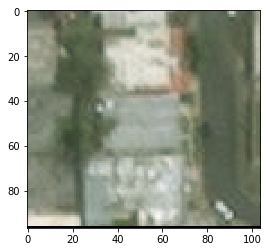

In [85]:
# Explore different zoom levels
# First zoom level (pre-tuning): 0.00016

import random
from rasterio.mask import mask
from rasterio import plot

i = int(random.random()*len(buildings_tile_map))
print(i)
i = 666242
row = buildings_tile_map.iloc[i]

with rasterio.open(row['tile_filename']) as src:
    building = row['geometry']
    x, y = 0., 0.
    # Add a small square buffer to the building polygon before cropping
    p = building.buffer(0.00016, cap_style=3).envelope
    x, y = p.centroid.x, p.centroid.y
    out_img, out_transform = mask(src, [p], crop=True)
    plot.show(out_img)

In [91]:
# Crop out building from the tile, and save it in a separate file
# as a 128x128 px image.

# Hyperparameters here are:
#     - image size
#     - buffer around the building

# There are a lot of buildings, start off with a smaller dataset. Ensure dataset is even, both
# in damaged and non-damaged, but also among damaged between 'affected' and 'destroyed' scenarios.

from rasterio.mask import mask

BASE_DIR = '/Users/apando/school/cs230/project/datasets/hurricane_maria/building_crops_zoom/'

NUM_DES_BLDG = 2000
NUM_AFF_BLDG = 2000
NUM_NO_DMG_BLDG = 4000

bldg_counter = 0
des_bldg_counter = 0
aff_bldg_counter = 0
no_dmg_bldg_counter = 0

for _, row in buildings_tile_map.sample(frac=1).iterrows():
    # Don't process *all* buildings, just a small sample.
    if (des_bldg_counter >= NUM_DES_BLDG) and (aff_bldg_counter >= NUM_AFF_BLDG) and (no_dmg_bldg_counter >= NUM_NO_DMG_BLDG):
        break
    
    building = row['geometry']
    x, y = 0., 0.
    with rasterio.open(row['tile_filename']) as src:
        # Add a small square buffer to the building polygon before cropping
        p = building.buffer(0.00006, cap_style=3).envelope
        x, y = p.centroid.x, p.centroid.y
        out_img, out_transform = mask(src, [p], crop=True)
    out_meta = src.meta.copy()
    
    # Save the resulting raster, as a 128x128 image
    out_meta.update({
        "driver": "JPEG",
        "height": 128,
        "width": 128,
        "transform": out_transform
    })
    
    # Set up data in Keras ImageDataGenerator-friendly format
    dmg_label = 'nd'
    if row['is_damaged']:
        if row['DMG_LEVEL'] == 'DES':
            if des_bldg_counter >= NUM_DES_BLDG:
                continue
            des_bldg_counter += 1
            dmg_label = 'des'
        if row['DMG_LEVEL'] == 'AFF':
            if aff_bldg_counter >= NUM_AFF_BLDG:
                continue
            aff_bldg_counter += 1
            dmg_label = 'aff'
        out_dir = BASE_DIR + 'damaged/'
    else:
        if no_dmg_bldg_counter >= NUM_NO_DMG_BLDG:
            continue
        no_dmg_bldg_counter += 1
        out_dir = BASE_DIR + 'non_damaged/'        
    
    # Preserve tile name in case there's multiple images for 1 building (don't overwrite)
    tile_name = row['tile_filename'].split('/')[-1].split('.')[0]
        
    with rasterio.open(out_dir + '{0},{1}_{2}_{3}.tif'.format(x, y, tile_name, dmg_label), 'w', **out_meta) as dest:
        dest.write(out_img)
    bldg_counter += 1
    
    if bldg_counter % 200 == 0:
        print("Processed {} buildings...".format(bldg_counter))
        
print("Processed {} buildings".format(bldg_counter))

Processed 200 buildings...
Processed 400 buildings...
Processed 600 buildings...
Processed 800 buildings...
Processed 1000 buildings...
Processed 1200 buildings...
Processed 1400 buildings...
Processed 1600 buildings...
Processed 1800 buildings...
Processed 2000 buildings...
Processed 2200 buildings...
Processed 2400 buildings...
Processed 2600 buildings...
Processed 2800 buildings...
Processed 3000 buildings...
Processed 3200 buildings...
Processed 3400 buildings...
Processed 3600 buildings...
Processed 3800 buildings...
Processed 4000 buildings...
Processed 4200 buildings...
Processed 4400 buildings...
Processed 4600 buildings...
Processed 4800 buildings...
Processed 5000 buildings...
Processed 5200 buildings...
Processed 5400 buildings...
Processed 5600 buildings...
Processed 5800 buildings...
Processed 6000 buildings...
Processed 6200 buildings...
Processed 6400 buildings...
Processed 6600 buildings...
Processed 6800 buildings...
Processed 7000 buildings...
Processed 7200 buildings

In [4]:
# Try out balancing classes (NOTE: this is no longer necessary after sampling scheme above)
import numpy as np
import os

from random import shuffle

ORIG_BASE_DIR = '/Users/apando/school/cs230/project/datasets/hurricane_maria/building_crops/'
TRIM_BASE_DIR = '/Users/apando/school/cs230/project/datasets/hurricane_maria/building_crops_even/'

for c in ('damaged/', 'non_damaged/'):
    all_images = np.array(os.listdir(ORIG_BASE_DIR + c))
    print("Num {0} images to process: {1}".format(c, str(len(all_images))))
    img_idx = list(range(len(all_images)))
    shuffle(img_idx)
    print(img_idx[0:5])
    num_processed = 0
    for i in img_idx[0:38600]:
        os.system("cp {0} {1}".format(ORIG_BASE_DIR + c + all_images[i], TRIM_BASE_DIR + c + all_images[i]))
        num_processed += 1
        if num_processed % 10000 == 0:
            print("Processed {0} {1} images...".format(num_processed, c))
    print("Copied {0} {1} images total".format(num_processed, c))

Num damaged/ images to process: 38624
[18861, 26991, 14016, 9145, 23318]
Processed 10000 damaged/ images...
Processed 20000 damaged/ images...
Processed 30000 damaged/ images...
Copied 38600 damaged/ images total
Num non_damaged/ images to process: 1282363
[571971, 930576, 25632, 707920, 1113605]
Processed 10000 non_damaged/ images...
Processed 20000 non_damaged/ images...
Processed 30000 non_damaged/ images...
Copied 38600 non_damaged/ images total


In [5]:
# Split out onto a smaller dataset to test out transfer learning. (NOTE: this is no longer necessary after sampling scheme above)
import numpy as np
import os

from random import shuffle

ORIG_BASE_DIR = '/Users/apando/school/cs230/project/datasets/hurricane_maria/building_crops/'
TRIM_BASE_DIR = '/Users/apando/school/cs230/project/datasets/hurricane_maria/building_crops_small/'

# Add to train set
train_coords = set()
for c in ('damaged/', 'non_damaged/'):
    all_images = np.array(os.listdir(ORIG_BASE_DIR + c))
    print("Num {0} images to process: {1}".format(c, str(len(all_images))))
    img_idx = list(range(len(all_images)))
    shuffle(img_idx)
    print(img_idx[0:5])
    num_processed = 0
    for i in img_idx[0:2000]:
        os.system("cp {0} {1}".format(ORIG_BASE_DIR + c + all_images[i], TRIM_BASE_DIR + 'train/' + c + all_images[i]))
        train_coords.add(all_images[i].split('_')[0])
        num_processed += 1
        if num_processed % 500 == 0:
            print("Processed {0} {1} images...".format(num_processed, c))
    print("Copied {0} {1} images total".format(num_processed, c))
    
# Add to test set
for c in ('damaged/', 'non_damaged/'):
    all_images = np.array(os.listdir(ORIG_BASE_DIR + c))
    img_idx = list(range(len(all_images)))
    shuffle(img_idx)
    print(img_idx[0:5])
    i = 0
    num_processed = 0
    while num_processed <= 200:
        curr_fname = all_images[img_idx[i]]
        if curr_fname.split('_')[0] in train_coords:
            # Skip the building, even if it's not in the same tile as in training.
            print("Skipping train building")
            i += 1
            continue
        os.system("cp {0} {1}".format(ORIG_BASE_DIR + c + curr_fname, TRIM_BASE_DIR + 'test/' + c + curr_fname))
        num_processed += 1
        i += 1
        if num_processed % 20 == 0:
            print("Processed {0} {1} images...".format(num_processed, c))
    print("Copied {0} {1} images total".format(num_processed, c))
    print("Iterated thru {0} {1} images total".format(i, c))

Num damaged/ images to process: 38624
[24733, 19654, 14909, 9164, 21272]
Processed 500 damaged/ images...
Processed 1000 damaged/ images...
Processed 1500 damaged/ images...
Processed 2000 damaged/ images...
Copied 2000 damaged/ images total
Num non_damaged/ images to process: 1282363
[1089641, 529799, 220703, 842584, 1069057]
Processed 500 non_damaged/ images...
Processed 1000 non_damaged/ images...
Processed 1500 non_damaged/ images...
Processed 2000 non_damaged/ images...
Copied 2000 non_damaged/ images total
[31417, 2862, 30300, 11654, 26653]
Skipping train building
Skipping train building
Processed 20 damaged/ images...
Skipping train building
Processed 40 damaged/ images...
Skipping train building
Skipping train building
Processed 60 damaged/ images...
Skipping train building
Skipping train building
Skipping train building
Skipping train building
Processed 80 damaged/ images...
Skipping train building
Skipping train building
Skipping train building
Processed 100 damaged/ images..

In [7]:
# Add a validation set (NOTE: this is no longer necessary after sampling scheme above)
import numpy as np
import os

from random import shuffle

ORIG_BASE_DIR = '/Users/apando/school/cs230/project/datasets/hurricane_maria/building_crops/'
SMALL_BASE_DIR = '/Users/apando/school/cs230/project/datasets/hurricane_maria/building_crops_small/'

train_test_images = set()
# Get train+test sets
for t in ('train/', 'test/'):
    for c in ('damaged/', 'non_damaged/'):
              curr_images = os.listdir(SMALL_BASE_DIR + t + c)
              train_test_images.update(curr_images)
              print("Added {0} {1} {2} images".format(len(curr_images), t, c))

print("Added {} images total".format(len(train_test_images)))
              
# Add to validate set
for c in ('damaged/', 'non_damaged/'):
    all_images = np.array(os.listdir(ORIG_BASE_DIR + c))
    img_idx = list(range(len(all_images)))
    shuffle(img_idx)
    print(img_idx[0:5])
    i = 0
    num_processed = 0
    while num_processed <= 200:
        curr_fname = all_images[img_idx[i]]
        if curr_fname in train_test_images:
            # Skip the building, even if it's not in the same tile as in training.
            print("Skipping train building")
            i += 1
            continue
        os.system("cp {0} {1}".format(ORIG_BASE_DIR + c + curr_fname, SMALL_BASE_DIR + 'validate/' + c + curr_fname))
        num_processed += 1
        i += 1
        if num_processed % 20 == 0:
            print("Processed {0} {1} images...".format(num_processed, c))
    print("Copied {0} {1} images total".format(num_processed, c))
    print("Iterated thru {0} {1} images total".format(i, c))

Added 1186 train/ damaged/ images
Added 1379 train/ non_damaged/ images
Added 113 test/ damaged/ images
Added 109 test/ non_damaged/ images
Added 2784 images total
[35530, 29967, 33560, 26869, 32578]
Skipping train building
Processed 20 damaged/ images...
Skipping train building
Skipping train building
Processed 40 damaged/ images...
Processed 60 damaged/ images...
Skipping train building
Processed 80 damaged/ images...
Processed 100 damaged/ images...
Processed 120 damaged/ images...
Skipping train building
Processed 140 damaged/ images...
Processed 160 damaged/ images...
Skipping train building
Processed 180 damaged/ images...
Processed 200 damaged/ images...
Copied 201 damaged/ images total
Iterated thru 207 damaged/ images total
[120481, 413840, 82418, 937179, 807379]
Processed 20 non_damaged/ images...
Processed 40 non_damaged/ images...
Processed 60 non_damaged/ images...
Processed 80 non_damaged/ images...
Processed 100 non_damaged/ images...
Processed 120 non_damaged/ images...